In [365]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I really like pizza (Domino's is my favorite pizza chain), and I really like statistics. So, I'm going to forecast Domino's Pizza closing stock prices (\$DPZ) using classical time series techniques, ML, and deep learning.

In [366]:
!pip install yfinance

In [367]:
import statsmodels.tsa.api as tsa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow import keras

import yfinance as yf

from tqdm import tqdm

# The Data

In [368]:
dominos = yf.download('DPZ', start='2007-01-01', end='2023-12-01')
dominos.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,27.799999,28.190001,27.780001,28.040001,13.429073,533600
2007-01-04,28.040001,28.430000,27.700001,28.360001,13.582334,336400
2007-01-05,28.250000,28.250000,27.990000,28.000000,13.409915,229900
2007-01-08,27.900000,28.150000,27.549999,28.000000,13.409915,777800
2007-01-09,28.010000,28.500000,28.010000,28.500000,13.649379,468200


In [369]:
dominos.shape

(4258, 6)

Text(0, 0.5, 'Price ($USD)')

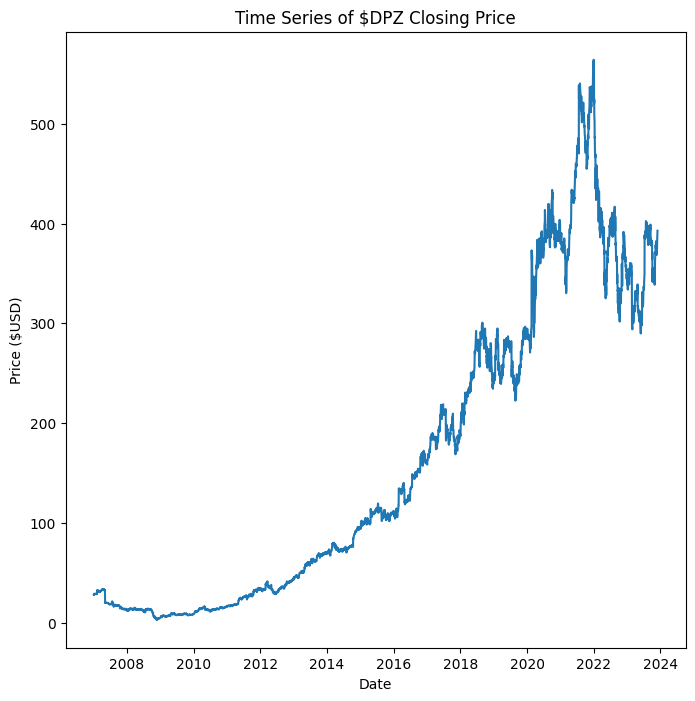

In [370]:
plt.figure(figsize = (8, 8))
plt.plot(dominos['Close'])
plt.title("Time Series of $DPZ Closing Price")
plt.xlabel("Date")
plt.ylabel("Price ($USD)")

The data are clearly not stationary.

We will define the target variable corresponding to a specific day to be the closing price of the next recorded day.

In [371]:
# desired ticker to analyse/predict
target_ticker = 'DPZ'

# build a dataframe with 3 columns: date, close price, target price (for the prediction)
df = pd.DataFrame({'Date': dominos.index, 'Close': dominos['Close']})

# Build the target prices i.e. the next day's close price
df['Target'] = df['Close'].shift(-1) # Target stock price today will be tomorrow's price

# Remove the last row as it will be a NaN for the target column
price_target_df = df[:-1]
price_target_df

,Date,Close,Target
Date,,,
2007-01-03,2007-01-03,28.040001,28.360001
2007-01-04,2007-01-04,28.360001,28.000000
2007-01-05,2007-01-05,28.000000,28.000000
2007-01-08,2007-01-08,28.000000,28.500000
2007-01-09,2007-01-09,28.500000,28.620001
...,...,...,...
2023-11-22,2023-11-22,369.489990,370.320007
2023-11-24,2023-11-24,370.320007,387.070007
2023-11-27,2023-11-27,387.070007,388.269989


In [372]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
price_target_df_scaled = scaler.fit_transform(price_target_df.drop(columns = 'Date'))

In [373]:
price_target_df_scaled = pd.DataFrame(price_target_df_scaled, index = price_target_df.index,
                                      columns = ["Close", "Target"])
price_target_df_scaled['Date'] = price_target_df_scaled.index
price_target_df_scaled

,Close,Target,Date
Date,,,
2007-01-03,0.044898,0.045467,2007-01-03
2007-01-04,0.045467,0.044826,2007-01-04
2007-01-05,0.044826,0.044826,2007-01-05
2007-01-08,0.044826,0.045717,2007-01-08
2007-01-09,0.045717,0.045931,2007-01-09
...,...,...,...
2023-11-22,0.653001,0.654479,2023-11-22
2023-11-24,0.654479,0.684310,2023-11-24
2023-11-27,0.684310,0.686447,2023-11-27


Training data will be the data from 2007 - 2017, Validation will be 2018 - 2023.

In [374]:
start_date = '2007-01-01'
end_date = '2018-12-31'
train = price_target_df_scaled[(price_target_df_scaled['Date'] >= start_date) & (price_target_df_scaled['Date'] <= end_date)]
test = price_target_df_scaled[(price_target_df_scaled['Date'] > end_date)]

In [375]:
train

,Close,Target,Date
Date,,,
2007-01-03,0.044898,0.045467,2007-01-03
2007-01-04,0.045467,0.044826,2007-01-04
2007-01-05,0.044826,0.044826,2007-01-05
2007-01-08,0.044826,0.045717,2007-01-08
2007-01-09,0.045717,0.045931,2007-01-09
...,...,...,...
2018-12-24,0.412324,0.438255,2018-12-24
2018-12-26,0.438255,0.437471,2018-12-26
2018-12-27,0.437471,0.440107,2018-12-27


In [376]:
test

,Close,Target,Date
Date,,,
2019-01-02,0.428264,0.421834,2019-01-02
2019-01-03,0.421834,0.428798,2019-01-03
2019-01-04,0.428798,0.433838,2019-01-04
2019-01-07,0.433838,0.426322,2019-01-07
2019-01-08,0.426322,0.434123,2019-01-08
...,...,...,...
2023-11-22,0.653001,0.654479,2023-11-22
2023-11-24,0.654479,0.684310,2023-11-24
2023-11-27,0.684310,0.686447,2023-11-27


# Classical Approach (statsmodels)

In [377]:
import statsmodels.api as sm

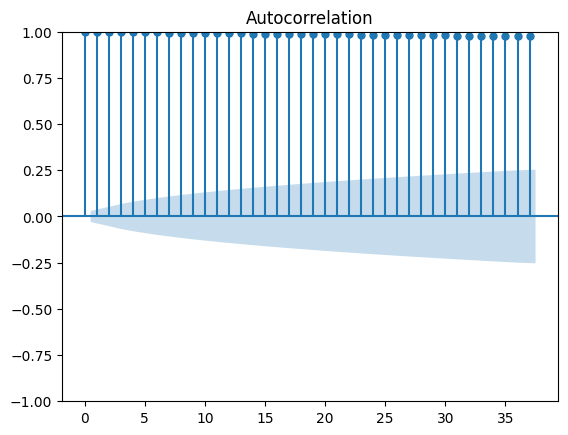

In [378]:
#ACF Plot
sm.graphics.tsa.plot_acf(dominos['Close'])
plt.show()

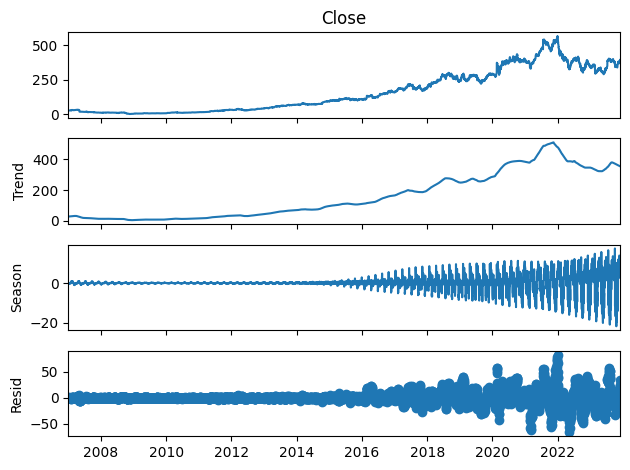

In [379]:
from statsmodels.tsa.seasonal import STL
res = STL(dominos['Close'], period = 52, seasonal = 31, robust = True).fit()
res.plot()
plt.show()

In [380]:
!pip install pmdarima

In [381]:
from pmdarima.arima import auto_arima

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

## Fitting on all data

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,1)[4] intercept   : BIC=-29435.737, Time=2.30 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=-29442.527, Time=0.71 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=-29458.014, Time=2.86 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=-29457.076, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=-29449.202, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : BIC=-29465.040, Time=0.65 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : BIC=-29457.954, Time=1.61 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : BIC=-29454.329, Time=4.11 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : BIC=-29456.909, Time=1.67 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : BIC=-29456.795, Time=2.51 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : BIC=-29464.170, Time=1.68 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : BIC=-29448.667, Time=7.14 sec
 ARIMA(1,1,0)(0,0,0)[4]             : BIC=-29471.405, Time=0.32 sec
 ARIMA(1,1,0)(1,0,0)[4]             : BIC=-29464.310, Time=0.77 sec
 ARIM

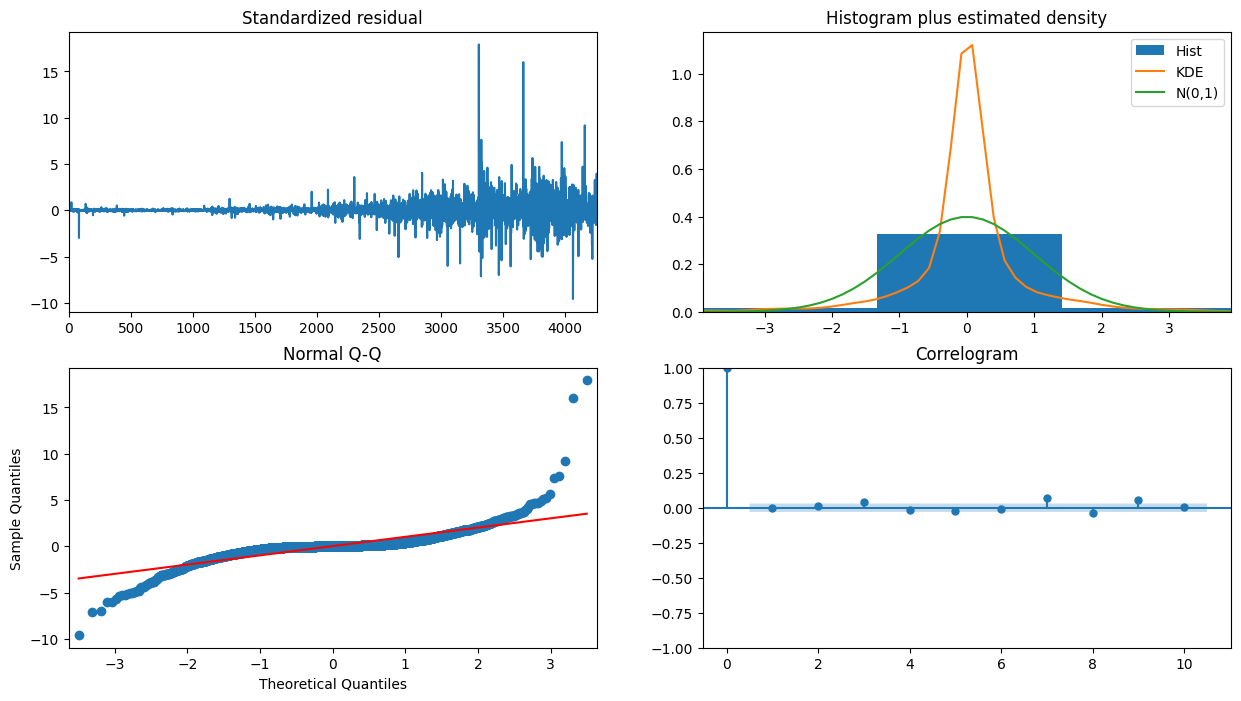

In [382]:
#With seasonality
model_autoARIMA = auto_arima(price_target_df_scaled['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # frequency of series, 4 corresponds to quarterly
                      d=None,           # let model determine 'd'
                      seasonal=True,
                      start_P=0, max_P=3, max_D=2, max_Q=3,
                      information_criterion = 'bic', #BIC is more conservative in parameters
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29455.239, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29484.108, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29483.238, Time=2.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29455.558, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29482.333, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29482.220, Time=2.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29480.448, Time=5.81 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29484.117, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29482.372, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-29482.245, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-29483.236, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-29480.416, Time=2.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 19.541 seconds
                               SARIMAX Results                 

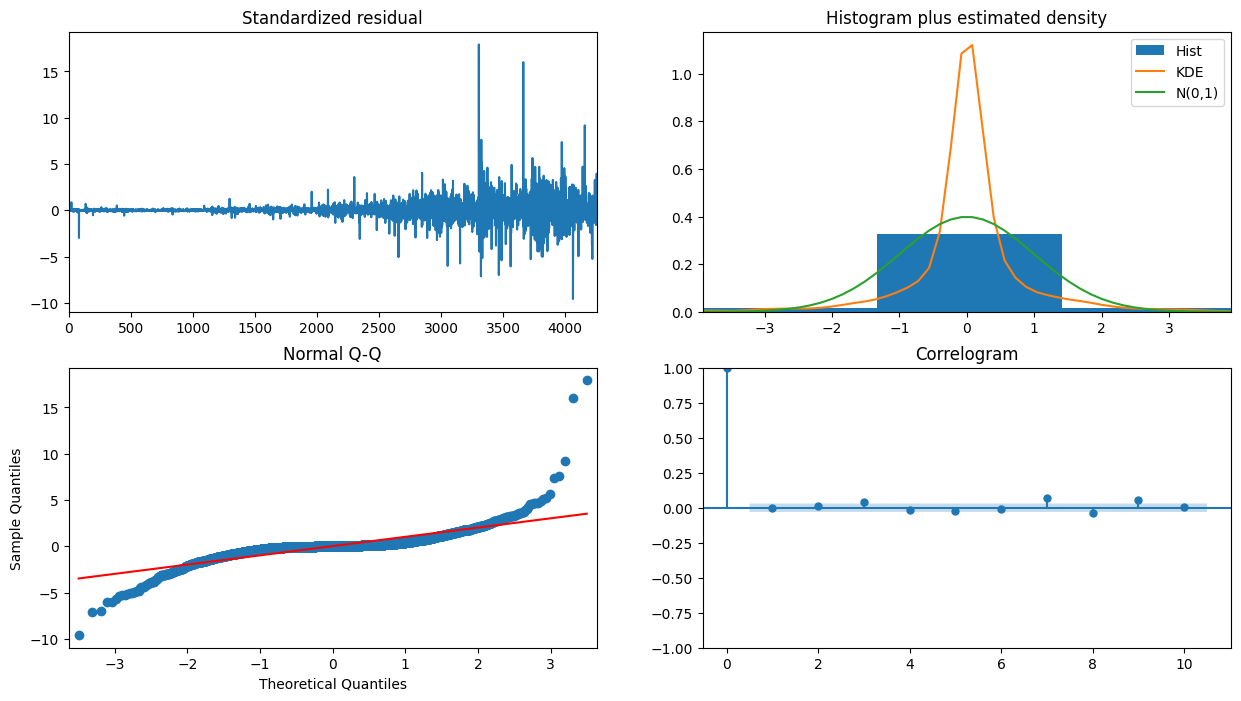

In [383]:
#Without seasonality
model_autoARIMA_no_season = auto_arima(price_target_df_scaled['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_no_season.summary())
model_autoARIMA_no_season.plot_diagnostics(figsize=(15,8))
plt.show()

In [384]:
from statsmodels.tsa.arima.model import ARIMA

In [385]:
model = ARIMA(price_target_df_scaled['Close'], order=(1,1,0))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4257
Model:                 ARIMA(1, 1, 0)   Log Likelihood               14744.059
Date:                Wed, 03 Jan 2024   AIC                         -29484.117
Time:                        07:18:46   BIC                         -29471.405
Sample:                             0   HQIC                        -29479.625
                               - 4257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0846      0.008    -11.008      0.000      -0.100      -0.070
sigma2      5.736e-05   2.43e-07    236.041      0.000    5.69e-05    5.78e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [386]:
predictions = fitted.predict(start = "2019-01-02", end = "2023-11-29")
predictions

Date
2019-01-02    0.436911
2019-01-03    0.428970
2019-01-04    0.422378
2019-01-07    0.428209
2019-01-08    0.433412
                ...   
2023-11-22    0.652558
2023-11-24    0.652974
2023-11-27    0.654354
2023-11-28    0.681786
2023-11-29    0.686266
Name: predicted_mean, Length: 1237, dtype: float64

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using ARIMA')

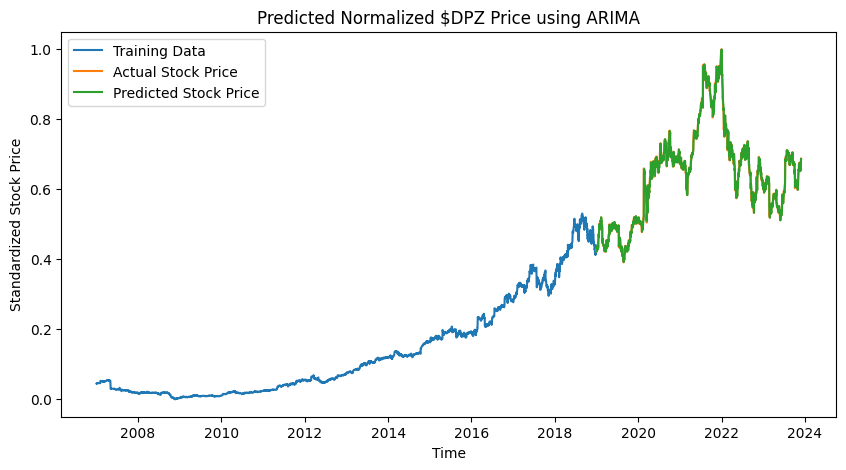

In [387]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using ARIMA')

In [388]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test['Close'], predictions)

0.00867257633897198

In [389]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test['Close'], predictions)

0.013715518371978446

The prediction error is quite small.

## Train/Test Split

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,1)[4] intercept   : BIC=-26018.839, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=-26023.809, Time=0.33 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=-26011.451, Time=1.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=-26011.650, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=-26026.989, Time=0.21 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : BIC=-26018.648, Time=1.05 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : BIC=-26012.413, Time=3.33 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : BIC=-26016.681, Time=1.39 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : BIC=-26016.689, Time=2.67 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : BIC=-26007.783, Time=1.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 14.591 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3020
Model:               SARIMAX(0, 1, 0)   L

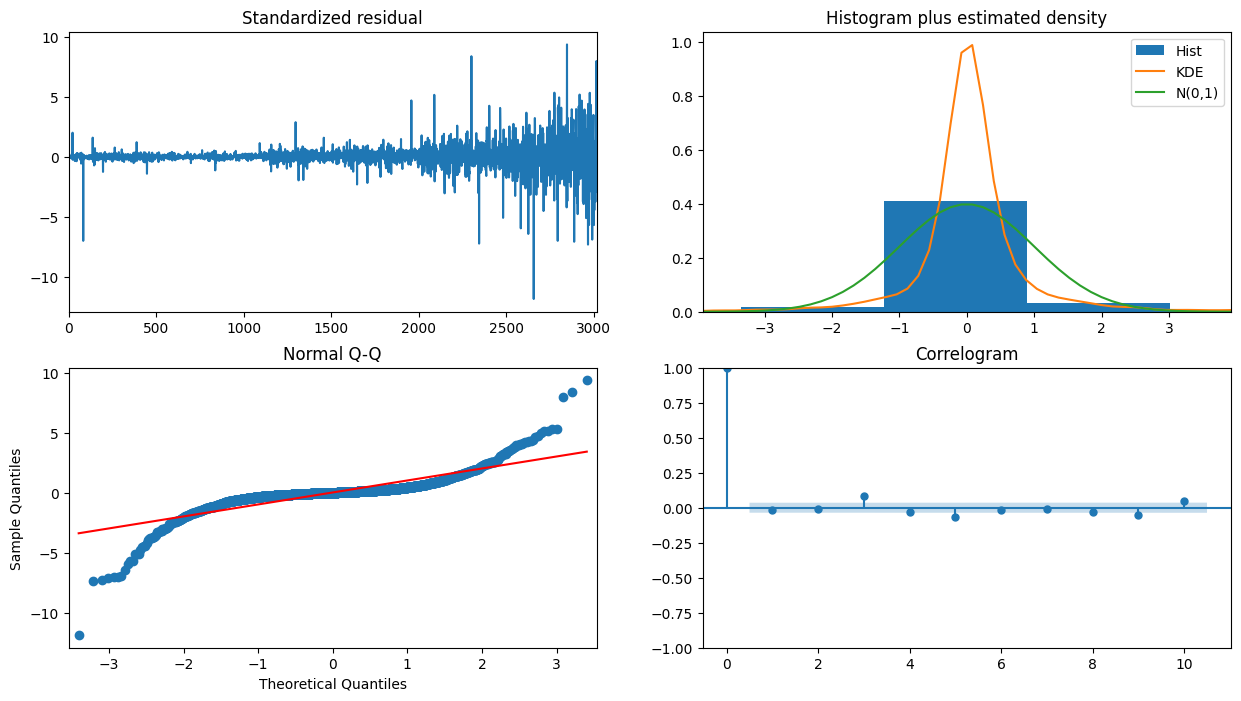

In [390]:
#With seasonality
model_autoARIMA = auto_arima(train['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # frequency of series, 4 corresponds to quarterly
                      d=None,           # let model determine 'd'
                      seasonal=True,
                      start_P=0, max_P=3, max_D=2, max_Q=3,
                      information_criterion = 'bic', #BIC is more conservative in parameters
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-26035.834, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26034.719, Time=1.39 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26034.727, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-26033.002, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-26031.834, Time=1.78 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 7.699 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3020
Model:               SARIMAX(0, 1, 0)   Log Likelihood               13019.917
Date:                Wed, 03 Jan 2024   AIC                         -26035.834
Time:                        07:19:10   BIC                         -26023.809
Sample:                             0   HQIC                        -26031.510
                               - 3020                             

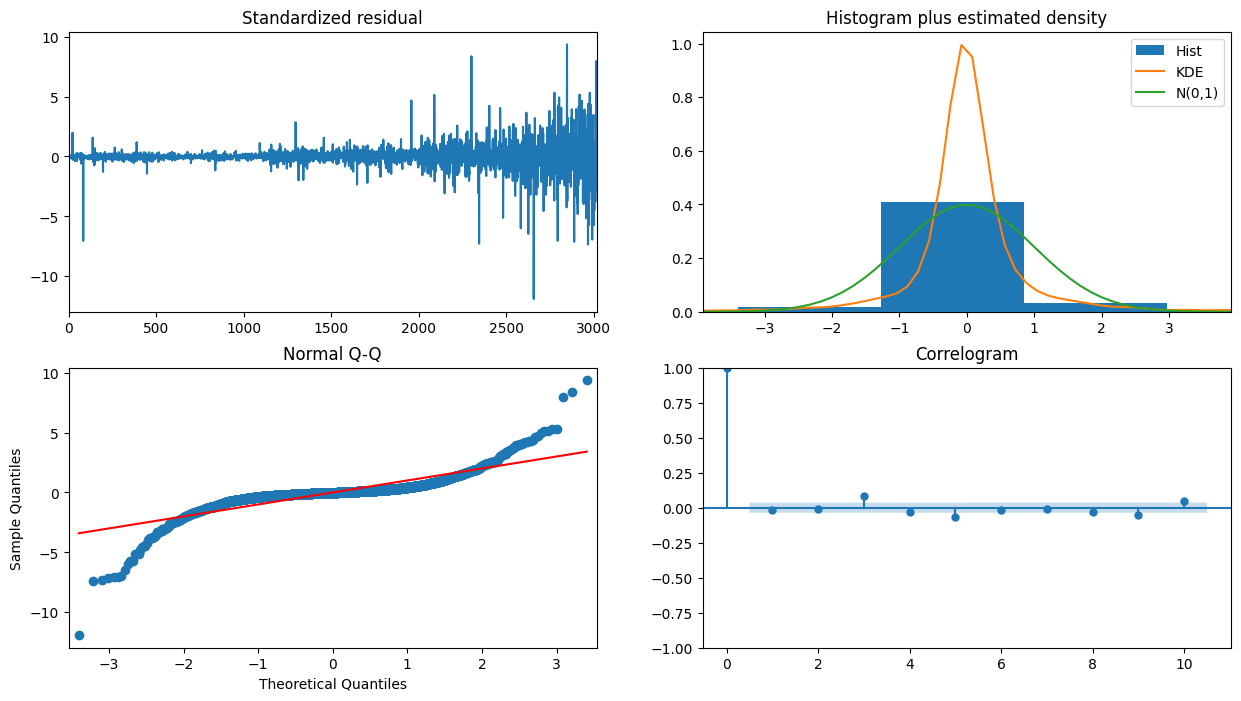

In [391]:
#Without seasonality
model_autoARIMA_no_season = auto_arima(train['Close'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA_no_season.summary())
model_autoARIMA_no_season.plot_diagnostics(figsize=(15,8))
plt.show()

The auto_arima function suggests an ARIMA(0, 1, 0) model, which is a random walk.

We can see this by noticing that the ARIMA(0, 1, 0) model is equivalent to

$$
Y_{t + 1} - Y_{t} = ϵ_{t + 1}
$$

where $ϵ_{t+1}$ is white noise. Rearranging, we get that

$$
Y_{t + 1} = Y_t + ϵ_t
$$

since $ϵ_{t + 1} = ϵ_t$ by definition of white noise. This is a random walk without drift.

We proceed by fitting this model on the entire dataset, and using the fitted values on the test indices as our test values.

In [392]:
from statsmodels.tsa.arima.model import ARIMA

In [393]:
model = ARIMA(price_target_df_scaled['Close'], order=(0,1,0))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 4257
Model:                 ARIMA(0, 1, 0)   Log Likelihood               14728.779
Date:                Wed, 03 Jan 2024   AIC                         -29455.558
Time:                        07:19:11   BIC                         -29449.202
Sample:                             0   HQIC                        -29453.312
                               - 4257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.774e-05   2.45e-07    235.741      0.000    5.73e-05    5.82e-05
Ljung-Box (L1) (Q):                  30.79   Jarque-Bera (JB):            447680.45
Prob(Q):                              0.00   Pr

In [394]:
predictions = fitted.predict(start = "2019-01-02", end = "2023-11-29")
predictions

Date
2019-01-02    0.436616
2019-01-03    0.428264
2019-01-04    0.421834
2019-01-07    0.428798
2019-01-08    0.433838
                ...   
2023-11-22    0.652680
2023-11-24    0.653001
2023-11-27    0.654479
2023-11-28    0.684310
2023-11-29    0.686447
Name: predicted_mean, Length: 1237, dtype: float64

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using ARIMA')

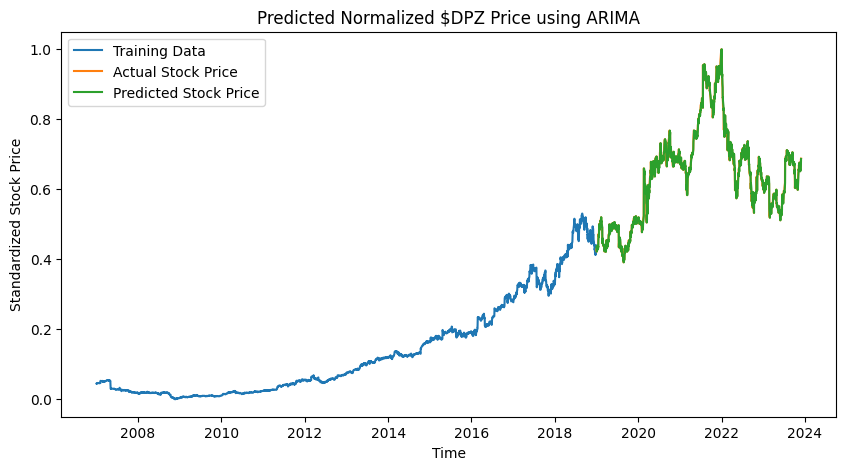

In [395]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using ARIMA')

In [396]:
mean_absolute_error(test['Close'], predictions)

0.008710715166327852

In [397]:
mean_absolute_percentage_error(test['Close'], predictions)

0.013781276526611895

This model performs quite similarly to the model training on the full dataset. This model is also much simpler, since it is a random walk.

# Machine Learning Approach (Ridge, Random Forests, LightGBM)

## Some EDA/Data Cleaning

In [398]:
dominos['Date'] = dominos.index

In [399]:
#pip install fastai

In [400]:
from fastai.tabular.all import *

#Generate date features
dominos = add_datepart(dominos, 'Date', drop=False)

In [401]:
#Predicted Value is the close price of the next day
dominos['Target'] = dominos['Close'].shift(-1)
dominos = dominos[:-1]

In [402]:
dominos.head()

,Open,High,Low,Close,Adj Close,Volume,Date,Year,Month,Week,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Target
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,27.799999,28.190001,27.780001,28.040001,13.429073,533600,2007-01-03,2007,1,1,...,2,3,False,False,False,False,False,False,1.167782e+09,28.360001
2007-01-04,28.040001,28.430000,27.700001,28.360001,13.582334,336400,2007-01-04,2007,1,1,...,3,4,False,False,False,False,False,False,1.167869e+09,28.000000
2007-01-05,28.250000,28.250000,27.990000,28.000000,13.409915,229900,2007-01-05,2007,1,1,...,4,5,False,False,False,False,False,False,1.167955e+09,28.000000
2007-01-08,27.900000,28.150000,27.549999,28.000000,13.409915,777800,2007-01-08,2007,1,2,...,0,8,False,False,False,False,False,False,1.168214e+09,28.500000
2007-01-09,28.010000,28.500000,28.010000,28.500000,13.649379,468200,2007-01-09,2007,1,2,...,1,9,False,False,False,False,False,False,1.168301e+09,28.620001


In [403]:
dominos.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Date', 'Year',
       'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed', 'Target'],
      dtype='object')

We will use Open, Close, Volume, Year, Month, and Is_quarter_start as features.

From the ARIMA fit, we know that the closing price of the previous day is already a very good predictor of the next day's closing price.

In [404]:
vars = ["Open", "Close", "Volume", "Year", "Month", "Is_quarter_start", "Target"]

df = dominos.loc[:, vars]

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns = vars)

scaled_df['Date'] = dominos.index

In [405]:
start_date = '2007-01-01'
end_date = '2018-12-31'
train = scaled_df[(scaled_df['Date'] >= start_date) & (scaled_df['Date'] <= end_date)]
test = scaled_df[(scaled_df['Date'] > end_date)]

In [406]:
train.index = train['Date']
test.index = test['Date']

## Model

I will proceed using Ridge Regression, LASSO, Random Forests, and LightGBM.

In [407]:
#Getting features and target
features = ["Open", "Close", "Volume", "Year", "Month", "Is_quarter_start"]

X_train = train.loc[:, features]
X_test = test.loc[:, features]

y_train = train.loc[:, "Target"]
y_test = test.loc[:, "Target"]

### Ridge

In [408]:
#Testing values of alpha
from sklearn.linear_model import Ridge

# Define a list of alpha values to try
alpha_values = np.linspace(0, 5, num = 200)
test_losses = []

best_alpha = None
best_test_loss = float('inf')

# Iterate over alpha values
for alpha in alpha_values:
    # Fit Ridge Regression
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = ridge_model.predict(X_test)

    # Calculate mean absolute error (you can use other metrics if needed)
    test_loss = mean_absolute_error(y_test, y_pred)
    test_losses.append(test_loss)

    # Update the best alpha if the current model has lower test loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_alpha = alpha

# Fit the final Ridge Regression model with the best alpha
final_ridge_model = Ridge(alpha=best_alpha)
final_ridge_model.fit(X_train, y_train)

# Print the best alpha and the corresponding test loss
print(f"Best Alpha: {best_alpha}")
print(f"Best Test Loss: {best_test_loss}")

Best Alpha: 0.0
Best Test Loss: 0.008721521945301255


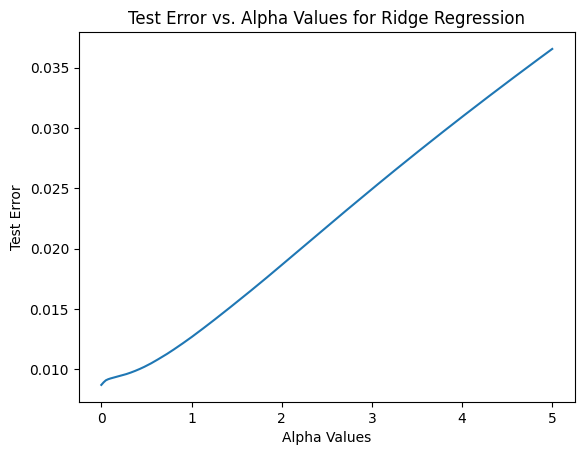

In [409]:
# Plot test error as a function of alpha
plt.plot(alpha_values, test_losses)
plt.xlabel('Alpha Values')
plt.ylabel('Test Error')
plt.title('Test Error vs. Alpha Values for Ridge Regression')
plt.show()

Interestingly, Ridge picks a value of $\alpha = 0$, which just corresponds to OLS.

In [410]:
final_ridge_model.coef_, final_ridge_model.feature_names_in_

(array([-2.11174617e-02,  1.01920375e+00,  1.44154958e-03,  1.67611006e-03,
        -3.58744789e-04, -3.11798667e-04]),
 array(['Open', 'Close', 'Volume', 'Year', 'Month', 'Is_quarter_start'],
       dtype=object))

Similar to what we saw from the ARIMA model, a very good predictor of tomorrow's closing price is the current closing price. This is further confirmed by the Ridge regression, which assigns a weight of 1 to the closing price, and small weights to all other features.

In [411]:
ridge_predictions = final_ridge_model.predict(X_test)
ridge_predictions = pd.Series(ridge_predictions, index = test.index)

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using Ridge')

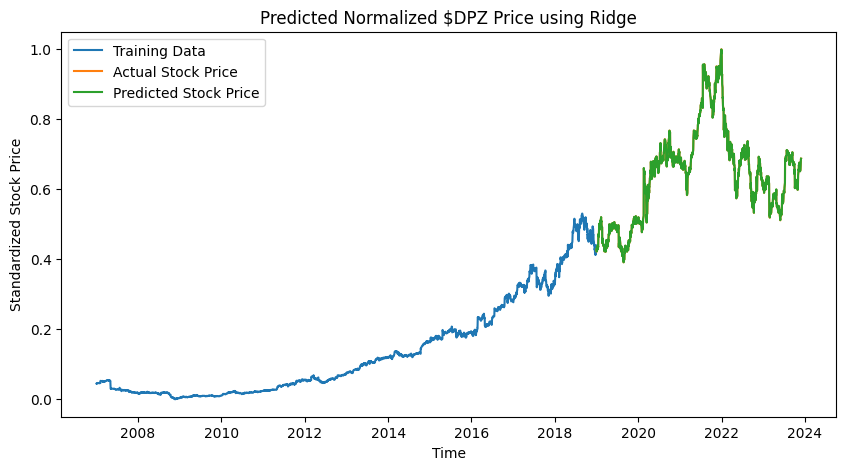

In [412]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(ridge_predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using Ridge')

In [413]:
mean_absolute_percentage_error(test['Close'], ridge_predictions)

0.00048323153269369415

Ridge provides similar results to the ARIMA.

### Random Forests

In [414]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

rf_regressor = RandomForestRegressor(n_estimators=1000)

# Define the hyperparameters to tune
param_grid = {
    'max_features': ['sqrt', 'log2', 1],
    'max_depth': [None, 1, 2, 3, 5, 7]
}

# Use TimeSeriesSplit for cross-validation
time_series_cv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object with TimeSeriesSplit
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=time_series_cv, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters
final_rf_model = RandomForestRegressor(**best_params)
final_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_rf_model.predict(X_test)

# Calculate mean absolute error
test_error = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and the corresponding test error
print("Best Hyperparameters:", best_params)
print("Test Error (MAE):", test_error)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt'}
Test Error (MAE): 0.14744944730147697


In [415]:
best_rf = RandomForestRegressor(n_estimators=1000, max_depth=None, max_features='sqrt')

best_rf.fit(X_train, y_train)

rf_predictions = best_rf.predict(X_test)

rf_predictions = pd.Series(rf_predictions, index = test.index)

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using Random Forest')

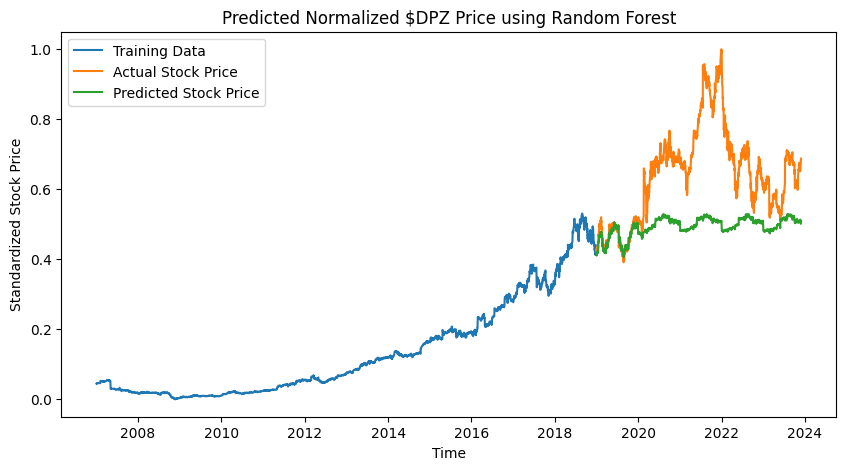

In [416]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(rf_predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using Random Forest')

In [417]:
mean_absolute_percentage_error(test['Close'], rf_predictions)

0.20592073221060447

Random Forests perform considerably worse than the previous methods. It performs decently well from 2018 to around 2020, then the performance drops considerably.

One thing to note is that the COVID pandemic happens around the same time of the performance drop, which also coincides with a sharp break in the general pattern of the stock prices.

Another likely reason is that the Random Forest algorithm is randomly selecting features for each of the subtrees. We already know from the Ridge regression and ARIMA that the feature which corresponds to the current day's close price is an extremely strong signal of the next day's closing price. It is likely that many of the trees do not consider the "Close" feature, which is the current day's closing price.

### LightGBM

In [418]:
import lightgbm as lgb

In [419]:
lgb_regressor = lgb.LGBMRegressor(verbose=-1)

# Define the hyperparameters to tune
param_grid = {
    'max_depth': [-1, 1, 2],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 150, 1000],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use TimeSeriesSplit for cross-validation
time_series_cv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object with TimeSeriesSplit
grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=time_series_cv, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Fit the final model with the best hyperparameters
final_lgb_model = lgb.LGBMRegressor(**best_params)
final_lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_lgb_model.predict(X_test)

# Calculate mean absolute error
test_error = mean_absolute_error(y_test, y_pred)

# Print the best hyperparameters and the corresponding test error
print("Best Hyperparameters:", best_params)
print("Test Error (MAE):", test_error)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 3020, number of used features: 6
[LightGBM] [Info] Start training from score 0.134467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Hyp

In [420]:
lgbm_predictions = pd.Series(y_pred, index=test.index)

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using LightGBM Regressor')

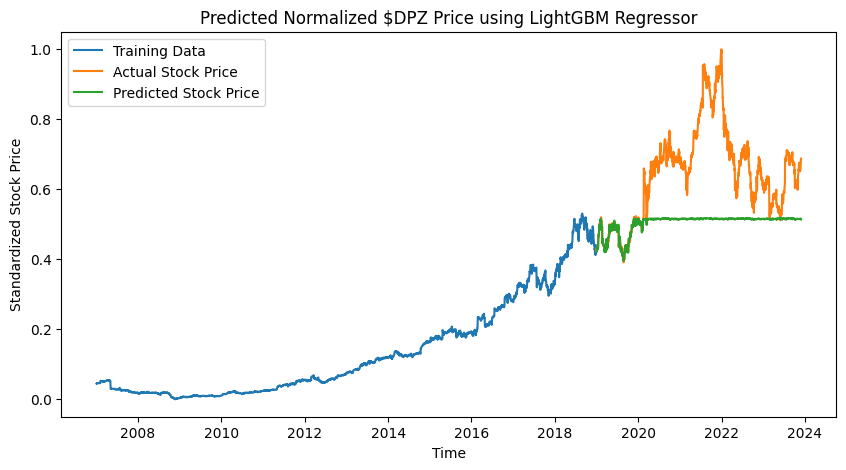

In [421]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(lgbm_predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using LightGBM Regressor')

In [422]:
mean_absolute_percentage_error(test['Close'], lgbm_predictions)

0.187563553327575

LightGBM has a slightly better performance than Random Forests, but performs overall quite similarly. This looks like it comes from a better fit in the test data leading up to 2020. Interestingly, past 2020 the LightGBM predicts a relatively constant value.

# Deep Learning (LSTM)

Ridge and ARIMA provide extremely high performance, and so deep learning is overkill from a real application perspective. We proceed for fun, and for the sake of comparison.

The simplicity of the Ridge and ARIMA models suggests that there may be a big need to combat overfitting with the LSTM.

In [423]:
#Creating tensors

train_array = train.drop(columns = 'Date').values
test_array = test.drop(columns = 'Date').values

X_train_tensor = train_array.reshape((train_array.shape[0], train_array.shape[1], 1))
X_test_tensor = test_array.reshape((test_array.shape[0], test_array.shape[1], 1))

In [424]:
input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2])

lstm = keras.Sequential()

lstm.add(keras.layers.LSTM(100, return_sequences=True, recurrent_dropout=0.1, input_shape=input_shape))
lstm.add(keras.layers.Dropout(0.3))

lstm.add(keras.layers.LSTM(100, recurrent_dropout=0.1, return_sequences=True))
lstm.add(keras.layers.Dropout(0.3))

lstm.add(keras.layers.LSTM(100, recurrent_dropout=0.1))
lstm.add(keras.layers.Dropout(0.3))

lstm.add(keras.layers.Dense(1, activation='linear'))

lstm.compile(optimizer='adam', loss="mae")

lstm.build(input_shape=input_shape)

lstm.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_57 (LSTM)              (None, 7, 100)            40800     
                                                                 
 dropout_48 (Dropout)        (None, 7, 100)            0         
                                                                 
 lstm_58 (LSTM)              (None, 7, 100)            80400     
                                                                 
 dropout_49 (Dropout)        (None, 7, 100)            0         
                                                                 
 lstm_59 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_50 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 1)               

In [425]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      restore_best_weights=True,
                      patience=4) #Stop training if loss does not decrease for 4 epochs and take the model with best validation loss

#Reduces learning rate by 30% if loss does not decrease in 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [early, learning_rate_reduction]

In [426]:
history = lstm.fit(X_train_tensor, y_train.values, epochs=30, batch_size=64,
                   validation_data=(X_test_tensor, y_test.values), callbacks=callbacks_list, shuffle = False)

Epoch 1/30
48/48 [==============================] - 12s 76ms/step - loss: 0.0255 - val_loss: 0.1184 - lr: 0.0010
Epoch 2/30
48/48 [==============================] - 3s 67ms/step - loss: 0.1024 - val_loss: 0.1837 - lr: 0.0010
Epoch 3/30
48/48 [==============================] - 3s 64ms/step - loss: 0.1549 - val_loss: 0.4852 - lr: 0.0010
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 0.1189
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
48/48 [==============================] - 3s 55ms/step - loss: 0.1189 - val_loss: 0.4588 - lr: 0.0010
Epoch 5/30
48/48 [==============================] - 3s 56ms/step - loss: 0.1162 - val_loss: 0.4523 - lr: 3.0000e-04


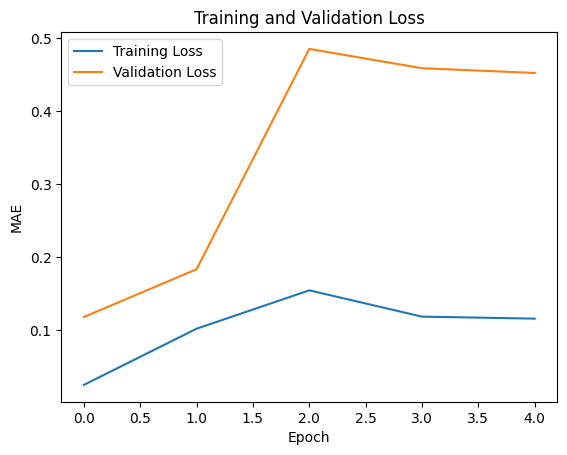

In [427]:
# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [428]:
lstm_predictions = lstm.predict(X_test_tensor)

lstm_predictions = pd.Series(lstm_predictions.flatten(), index = test.index)

39/39 [==============================] - 1s 9ms/step


In [429]:
mean_absolute_error(y_test, lstm_predictions)

0.1183804558265636

Text(0.5, 1.0, 'Predicted Normalized $DPZ Price using LSTM')

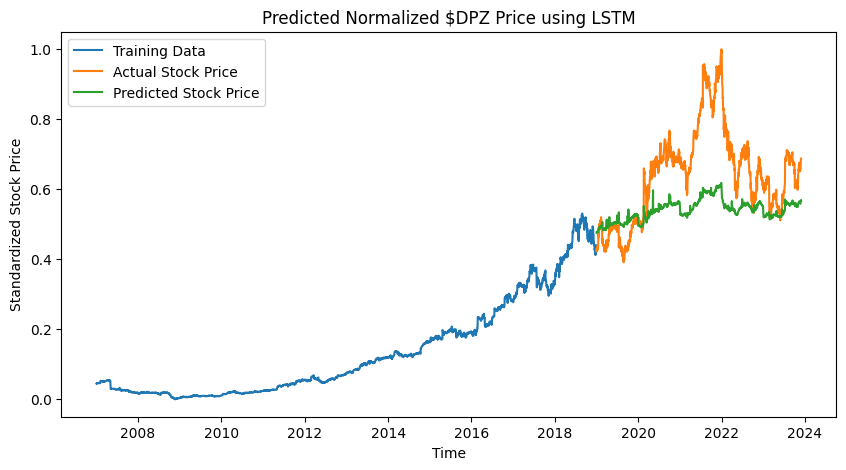

In [430]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train['Close'], label='Training Data')
plt.plot(test['Close'], label='Actual Stock Price')
plt.plot(lstm_predictions, label='Predicted Stock Price')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Standardized Stock Price')
plt.title('Predicted Normalized $DPZ Price using LSTM')

In [431]:
mean_absolute_percentage_error(y_test, lstm_predictions)

0.16729276722431796

The LSTM performs quite well, but not nearly as well as the ARIMA and Ridge. The LSTM predicts some big spikes, which are concerning for real world application. Along with the fact that we have to think of architectures for the LSTM, Ridge or ARIMA is definitely preferred.